# Let's looking into the E Jones Matrix, gonna have to revivie notebook from the past
### 7/8

In [10]:
import numpy as np, healpy as hp, matplotlib.pyplot as plt
import os, sys, glob, yaml
from glob import glob
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord, Galactic, AltAz
from astropy import units as u


import pygsm,time,copy
import pyuvdata.utils as uvutils
import json,itertools,shutil


import matplotlib

from astropy.coordinates import EarthLocation
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import gridspec
from pyuvdata import UVData
from datetime import datetime
from collections import OrderedDict as odict
from astropy.time import Time
from astropy_healpix import HEALPix
from astropy import constants as c
from copy import deepcopy
from sympy import *
init_printing(use_unicode=True)
from sympy.physics.quantum import TensorProduct

#
sys.path.insert(0,'/lustre/aoc/projects/hera/onevarez/')
sys.path.insert(0,'/lustre/aoc/projects/hera/onevarez/cst2ijones/')
from cst2ijones import spherical_coordinates_basis_transformation as scbt
from cst2ijones.jones_matrix_field  import InstrumentalJonesMatrixField
from cst2ijones.plotting import PlotMueller 


In [11]:
# given some frequency n, this function returns the proper file name.
def txtname(n):
    if n not in range(50,251):
        raise ValueError('no data at that frequency.')
    fname = '/lustre/aoc/projects/hera/onevarez/CST_Files/HERA_4.9m_E-pattern_ {}MHz.txt'.format(str(n))
    
    return fname

# Pauli Spin Matricies 
def StokesMatrix(n):
    if n not in [0,1,2,3]: raise Exception('Input must be an integer in [0,1,2,3]')
    
    if n == 0:
        p = np.array([[1.,0],[0.,1.]])
    elif n == 1:
        p = np.array([[1.,0],[0,-1.]])
    elif n == 2:
        p = np.array([[0,1.],[1.,0]])
    elif n == 3:
        p = np.array([[0., -1j],[1j,0]])
    
    return p

# Build Mueller Matrix elements from the pauli spin matrix given some jones matrix, J, at a certain frequency.
def MuellerMatrixElement(J,i,j):
    
    Pi = StokesMatrix(i)
    Pj = StokesMatrix(j)
    
    M_ij = np.einsum('...ab,...bc,...cd,...ad',Pi,J,Pj,J.conj()) / 2. #fancy way of taking the transpose
    
    M_ij = np.real(M_ij)
    
    return M_ij


In [12]:
nu0 = 150
print ("nu0 = {}".format(nu0))
nu_nodes = range(nu0-5,nu0+6)

input_files = [txtname(n) for n in nu_nodes]

# Initialize the Jones matrix with data from simulation
J = InstrumentalJonesMatrixField(input_files, nu_nodes)

# Calculate how to rotate to HERA's latitude
lat = 120.7215 # units of degrees. Remember it runs from [90,-90] so 120deg == -30deg
z0_cza = np.radians(lat) # theta on the sphere is the polar angle
z0 = scbt.r_hat(z0_cza, 0.) # directional vector on sphere (sin(theta)cos(phi),sin(theta)sin(phi),cos(theta))
RotAxis = np.array([0,-1,0])
RotAngle = z0_cza
R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

nu_axis = np.array([nu0]) #np.linspace(nu0-1.,nu0+1., 3, endpoint=True)

nu0 = 150


In [13]:
# BUILD PROPER GRID SIZE
# Determine the proper theta (rad) and phi (rad) values for a Sky Coordinate
# value at a specific HealPix pixel value.
path = '/lustre/aoc/projects/hera/jaguirre/PolarizedMosaics/2458098_sliced/zen.010601_011009.calibrated.HH.dirty.psf.fits'

# Load the FITS hdulits
data, header = fits.getdata(path, header=True)

In [14]:
#information about the location of the HERA observatory for alt az calculations
HERA_observatory = EarthLocation(lat=-30.960672*u.deg, lon=22.145934*u.deg, height=1000*u.m)
time = Time(header['DATE-OBS']) #time

In [15]:
# Parse the WCS keywords in the primary HDU
w = wcs.WCS(header)

# This won't work for rectangular images
npix_sq = header['NAXIS1']

# Convert Equitorial Coordinates to Spherical Coordinates grid
xpix, ypix = np.meshgrid(np.arange(npix_sq),np.arange(npix_sq), indexing='xy')

#Right ascension and declination as seen on the inside of the celestial sphere
ra, dec, dummy_freq, dummy_stokes = w.all_pix2world(xpix, ypix,1,1,1) 
c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs') # Coordinates Object

# Calculate rotation around -y (?) to get the beam to point at declination = latitude
z0_cza = np.radians(120.7215)
RotAxis = np.array([0,-1,0])
RotAngle = z0_cza
R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

phi =  np.radians(np.rad2deg(2 * np.pi) - altaz.az.value)

theta = np.radians(np.rad2deg(np.pi/2) - altaz.alt.value)

theta_hor = np.reshape(theta,-1)
phi_hor = np.reshape(phi,-1)
ijones_sq = np.reshape(J(nu_axis, theta_hor, phi_hor, R_z0.T),(len(nu_axis),npix_sq, npix_sq, 2, 2))

NameError: name 'altaz' is not defined

In [ ]:
ijo

In [8]:
#Awesome, I now Have the jones matrix i believe
print(ijones_sq.shape)

#let's reshape it
jones = ijones_sq.reshape(512,512,4,1)

(1, 512, 512, 2, 2)


In [12]:
real = np.real(jones)
imag = np.imag(jones)

new_hdu = fits.PrimaryHDU(data = real,header=header)
new_hdu.writeto('real-ejones.fits',overwrite=True)

new_hdu = fits.PrimaryHDU(data = imag,header=header)
new_hdu.writeto('imag-ejones.fits',overwrite=True)

np.save('complexjones',jones)

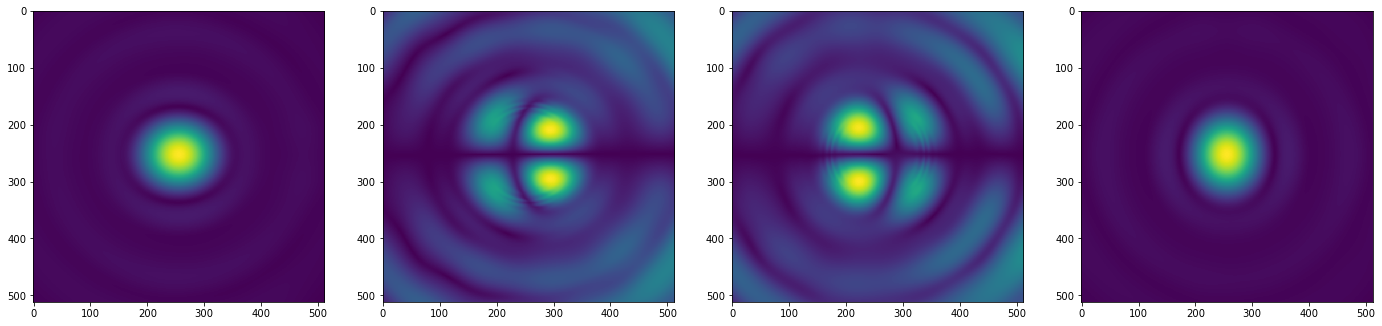

In [8]:
fig, axes = plt.subplots(figsize=(24,18),nrows=1, ncols=4, sharex=True,sharey=False)
axes[0].imshow(np.abs(jones.T[0][0]))
axes[1].imshow(np.abs(jones.T[0][1]))
axes[2].imshow(np.abs(jones.T[0][2]))
axes[3].imshow(np.abs(jones.T[0][3]))

# 7/9

In [13]:
def ejones_to_fits(ejones):
    """
    Make a fits file from a complex E Jones
    
    Arguments:
    ejones = in form of (nx,ny,4,1) : according to casa, (testing for this...)
    
    Returns two fits files of real and imaginary components of ejones in the working directory
    
    """
    
   
    
    #Real
    hdu = fits.PrimaryHDU()  #make empty fits header, fill it with data
    hdu.data = ejones.real
    
    #in future when casa shape is known, better to savve it at real_ejones.fits for usability
    hdu.writeto('R_{}_{}_{}_{}_jones.fits'.format(ejones.shape[0],ejones.shape[1],ejones.shape[2],ejones.shape[3]))
    
    #Imag
    hdu = fits.PrimaryHDU()
    hdu.data = ejones.imag
    hdu.writeto('I_{}_{}_{}_{}_jones.fits'.format(ejones.shape[0],ejones.shape[1],ejones.shape[2],ejones.shape[3]))
    
    
    return "Finished! Shape of input was {}_{}_{}_{}".format(ejones.shape[0],ejones.shape[1],ejones.shape[2],ejones.shape[3])



In [12]:
from glob import glob
def tclean_with_pbeam(realimage,imagimage):

    R_list = glob('casa_images/R*')
    I_list = glob('casa_images/I*')
    
    #first make vptable
    vp.setpbimage(telecope='OTHER',othertelescope='HERA',realimage=realimage,imagimage=imagimage)
    
    #save the vp table
    vp.saveastable('{}.tab'.format(realimage[0:13]))
    
    vp = '{}'.format(realimage[0:13])
    vp.loadfromtable('{}.tab'.format(realimage[0:13]))
    
    tclean(vis = '/lustre/aoc/projects/hera/nkern/CHAMP_Bootcamp/Lesson10_HERADataPartII/ \
              data/zen.2458116.24482.xx.HH.uvOCR.ms/',imagename='{}_nopb'.format(realimage[0:13]))
    
    tclean(vis = '/lustre/aoc/projects/hera/nkern/CHAMP_Bootcamp/Lesson10_HERADataPartII/ \
              data/zen.2458116.24482.xx.HH.uvOCR.ms/',imagename='{}_withpb'.format(realimage[0:13],vptable=vp))
           
    
    return